In [140]:
import pandas as pd
import numpy as np
import random as random
import pyarrow as pa 
import pyarrow.parquet as pq
from fastavro import writer, reader, parse_schema
import collections
import ta
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, ifft

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
d = "../data/raw/"
files = os.listdir(d)

clean_dir = "./data/clean/"
stat_dir = "./data/stat/"

In [22]:
def add_candle_indicators(
    df, 
    l, 
    ck, 
    hk, 
    lk, 
    vk
):
    df[l+'rsi'] = ta.rsi(df[ck])
    df[l+'mfi'] = ta.money_flow_index(df[hk], df[lk], df[ck], df[vk])
    df[l+'tsi'] = ta.tsi(df[ck])
    df[l+'uo'] = ta.uo(df[hk], df[lk], df[ck])
    df[l+'ao'] = ta.ao(df[hk], df[lk])
    df[l+'macd_diff'] = ta.macd_diff(df[ck])
    df[l+'vortex_pos'] = ta.vortex_indicator_pos(df[hk], df[lk], df[ck])
    df[l+'vortex_neg'] = ta.vortex_indicator_neg(df[hk], df[lk], df[ck])
    df[l+'vortex_diff'] = abs(df[l+'vortex_pos'] - df[l+'vortex_neg'])
    df[l+'trix'] = ta.trix(df[ck])
    df[l+'mass_index'] = ta.mass_index(df[hk], df[lk])
    df[l+'cci'] = ta.cci(df[hk], df[lk], df[ck])
    df[l+'dpo'] = ta.dpo(df[ck])
    df[l+'kst'] = ta.kst(df[ck])
    df[l+'kst_sig'] = ta.kst_sig(df[ck])
    df[l+'kst_diff'] = (df[l+'kst']-df[l+'kst_sig'])
    df[l+'aroon_up'] = ta.aroon_up(df[ck])
    df[l+'aroon_down'] = ta.aroon_down(df[ck])
    df[l+'aroon_ind'] = (df[l+'aroon_up']-df[l+'aroon_down'])
    df[l+'bbh'] = ta.bollinger_hband(df[ck])
    df[l+'bbl'] = ta.bollinger_lband(df[ck])
    df[l+'bbm'] = ta.bollinger_mavg(df[ck])
    df[l+'bbhi'] = ta.bollinger_hband_indicator(df[ck])
    df[l+'bbli'] = ta.bollinger_lband_indicator(df[ck])
    df[l+'kchi'] = ta.keltner_channel_hband_indicator(df[hk],df[lk],df[ck])
    df[l+'kcli'] = ta.keltner_channel_lband_indicator(df[hk],df[lk],df[ck])
    df[l+'dchi'] = ta.donchian_channel_hband_indicator(df[ck])
    df[l+'dcli'] = ta.donchian_channel_lband_indicator(df[ck])
    df[l+'adi'] = ta.acc_dist_index(df[hk],df[lk],df[ck],df[vk])
    df[l+'obv'] = ta.on_balance_volume(df[ck], df[vk])
    df[l+'cmf'] = ta.chaikin_money_flow(df[hk],df[lk],df[ck],df[vk])
    df[l+'fi'] = ta.force_index(df[ck], df[vk])
    df[l+'em'] = ta.ease_of_movement(df[hk], df[lk], df[ck], df[vk])
    df[l+'vpt'] = ta.volume_price_trend(df[ck], df[vk])
    df[l+'nvi'] = ta.negative_volume_index(df[ck], df[vk])
    df[l+'dr'] = ta.daily_return(df[ck])
    df[l+'dlr'] = ta.daily_log_return(df[ck])
    
    df[l+'ma50'] = df[ck].rolling(window=50).mean()
    df[l+'ma100'] = df[ck].rolling(window=100).mean()    
    df[l+'26ema'] = df[[ck]].ewm(span=26).mean()
    df[l+'12ema'] = df[[ck]].ewm(span=12).mean()
    df[l+'macd'] = (df[l+'12ema']-df[l+'26ema'])
    df[l+'100sd'] = df[[ck]].rolling(100).std()
    df[l+'upper_band'] = df[l+'ma100'] + (df[l+'100sd']*2)
    df[l+'lower_band'] = df[l+'ma100'] - (df[l+'100sd']*2)
    df[l+'ema'] = df[ck].ewm(com=0.5).mean()
    df[l+'momentum'] = df[ck]-1
    return df

In [23]:
records = []
with open('../data/aggregated/okex_spot_USDT_LTC_PT180S.avro', 'rb') as fo:
    for record in reader(fo):
        records.append(record)

df = pd.DataFrame(records)

df.set_index(['window_end'], inplace=True)
df.sort_index(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

df = add_candle_indicators(
    df,
    l='all_', 
    ck='all_close_price', 
    hk='all_high_price', 
    lk='all_low_price', 
    vk='all_volume'
)

df = add_candlKe_indicators(
    df,
    l='buy_', 
    ck='buy_close_price', 
    hk='buy_high_price', 
    lk='buy_low_price', 
    vk='buy_volume'
)

df = add_candle_indicators(
    df,
    l='sell_', 
    ck='sell_close_price', 
    hk='sell_high_price', 
    lk='sell_low_price', 
    vk='sell_volume'
)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

In [26]:
dfr = df.copy()

In [138]:
def add_fourier(df):
    fft = fft(df['all_close_price'].values)
    
    for num_ in [3, 6, 9, 100]:
        fft_m10= np.copy(fft)
        fft_m10[num_:-num_]=0
        df['fft_'+str(num_)] = sum(np.fft.ifft(fft_m10))
    return df

In [ ]:
dffft = add_fourier(dfr)
dffft[]]

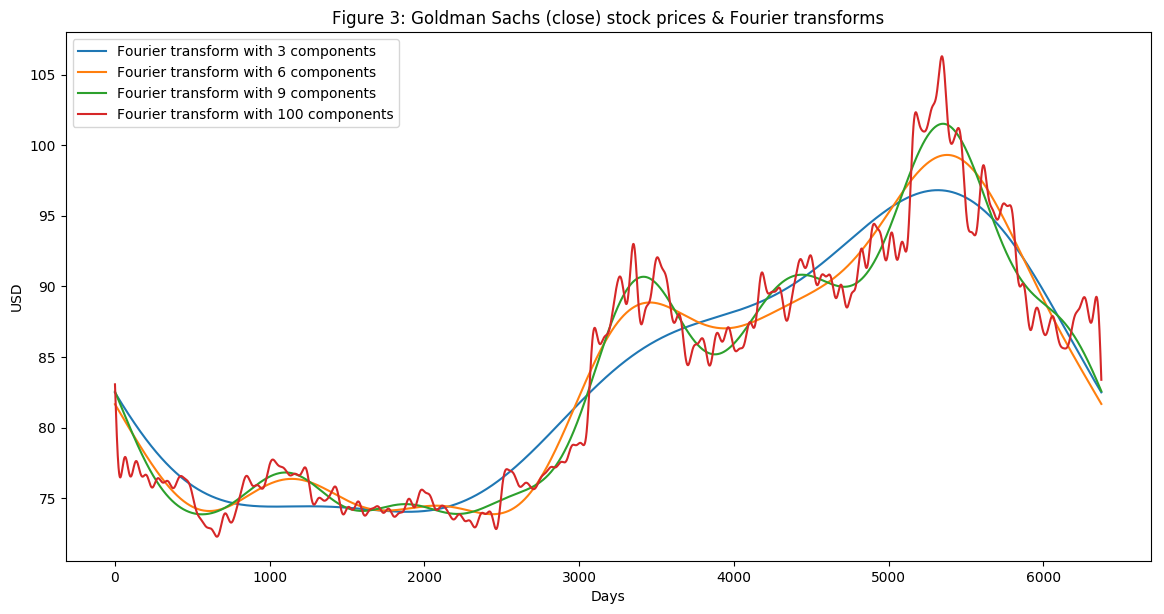

In [129]:
close_fft = np.fft.fft(np.asarray(dfr['all_close_price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list)
    fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [141]:
dff = df.copy()

In [142]:
def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [188]:
def get_weight_ffd(d, thres, lim):
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def frac_diff_ffd(x, d, thres=1e-5):
    w = get_weight_ffd(d, thres, len(x))
    width = len(w) - 1
    output = []
    output.extend([0] * width)
    for i in range(width, len(x)):
        output.append(np.dot(w.T, x[i - width:i + 1])[0])
    return np.array(output)

def logdiff(x):
    t = np.log(x)-np.log(x).shift(1)
    return t.fillna(method='bfill').fillna(method='ffill')

In [172]:
fd_close = fast_fracdiff(dff['all_close_price'], 0.4)

In [173]:
ffd_close = frac_diff_ffd(dff['all_close_price'], 0.4)

In [179]:
ffd2_close = frac_diff_ffd(dff['all_close_price'], 0.4, thres=1e-2)
ffd8_close = frac_diff_ffd(dff['all_close_price'], 0.4, thres=1e-8)


In [190]:
logdiff_close = logdiff(dff['all_close_price'])

In [193]:
adff = dff[['all_close_price']]

In [194]:
adff.insert(1, "fd_close", fd_close.tolist())

In [195]:
adff.insert(1, "ffd_close", ffd_close.tolist())
adff.insert(1, "ffd2_close", ffd2_close.tolist())
adff.insert(1, "ffd8_close", ffd8_close.tolist())
adff.insert(1, "logdiff_close", logdiff_close.tolist())

In [196]:
adff.head()

,all_close_price,logdiff_close,ffd8_close,ffd2_close,ffd_close,fd_close
window_end,,,,,,
1557011879999,77.65,0.001287,0.0,0.0,0.0,77.65000
1557012059999,77.75,0.001287,0.0,0.0,0.0,46.69000
1557012239999,77.66,-0.001158,0.0,0.0,0.0,37.24200
1557012419999,77.81,0.001930,0.0,0.0,0.0,32.44640
1557012599999,77.90,0.001156,0.0,0.0,0.0,29.25056


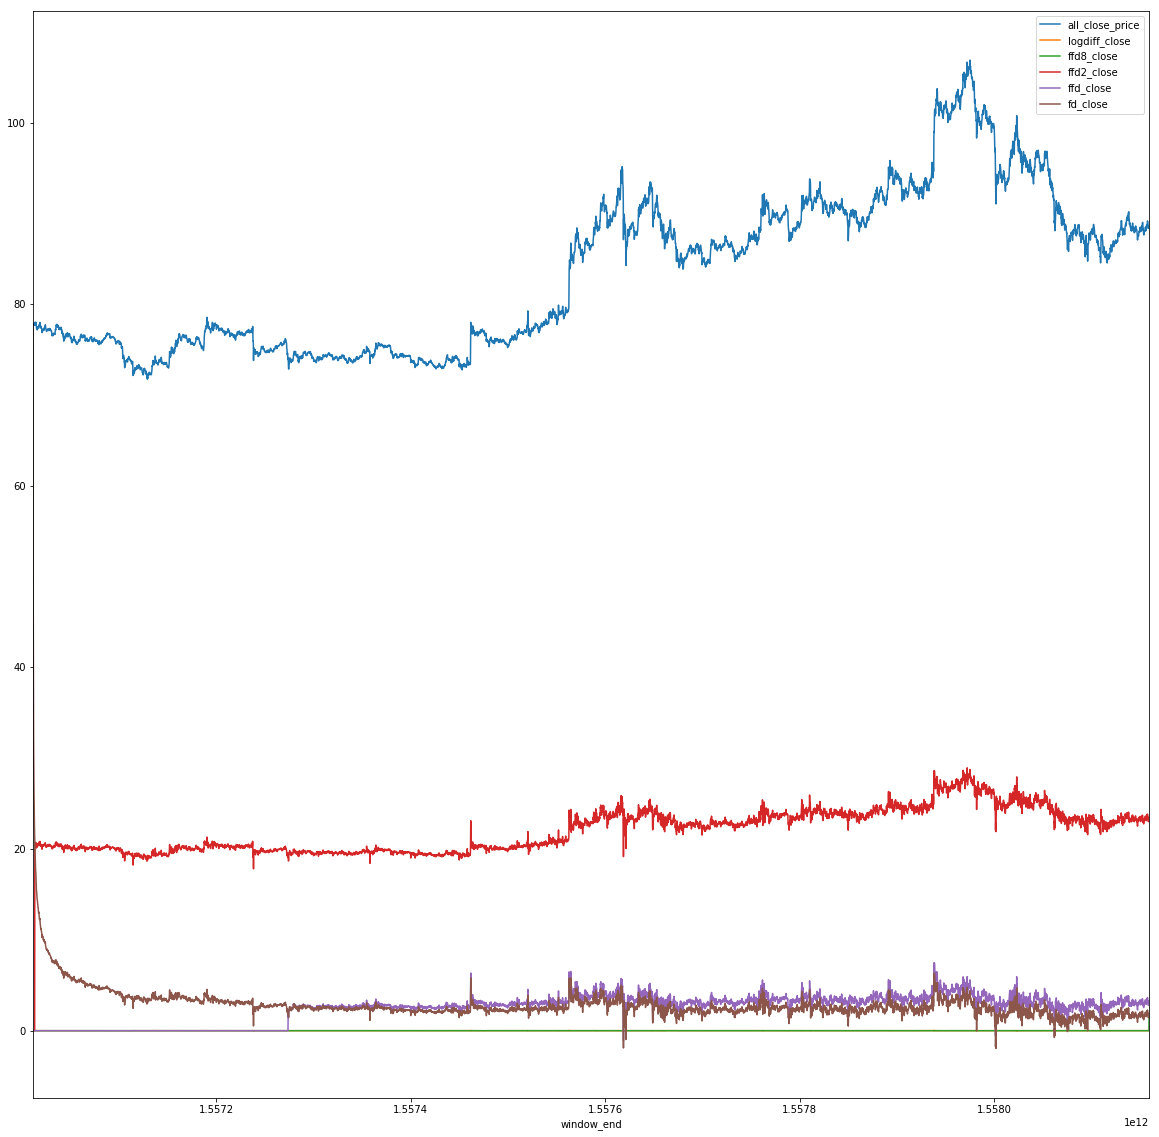

In [197]:
adff.plot(figsize=(20,20))

In [200]:
xdf = dff.copy()

In [209]:
metcol = [
    'interval',
    'quote_asset', 
    'base_asset',
    'exchange'
]

indcol = metcol + [
    'all_close_price', 
    'all_volume', 
    'all_high_price'
]

indf = xdf[indcol]

indf.rename(
    columns={
        "all_close_price": "close_price", 
        "all_volume":"volume", 
        "all_high_price": "high_price"
    }, 
    inplace=True
)

xdf.drop(
    columns=metcol, 
    inplace=True
)

/home/thorad/.conda/envs/bitcoin/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [210]:
for col in xdf.columns:
    try:
        xdf[col] = frac_diff_ffd(np.array(xdf[col], dtype=np.float), d=0.4)
    except Exception as e:
        print(xdf[[col]].head())
        print(e)

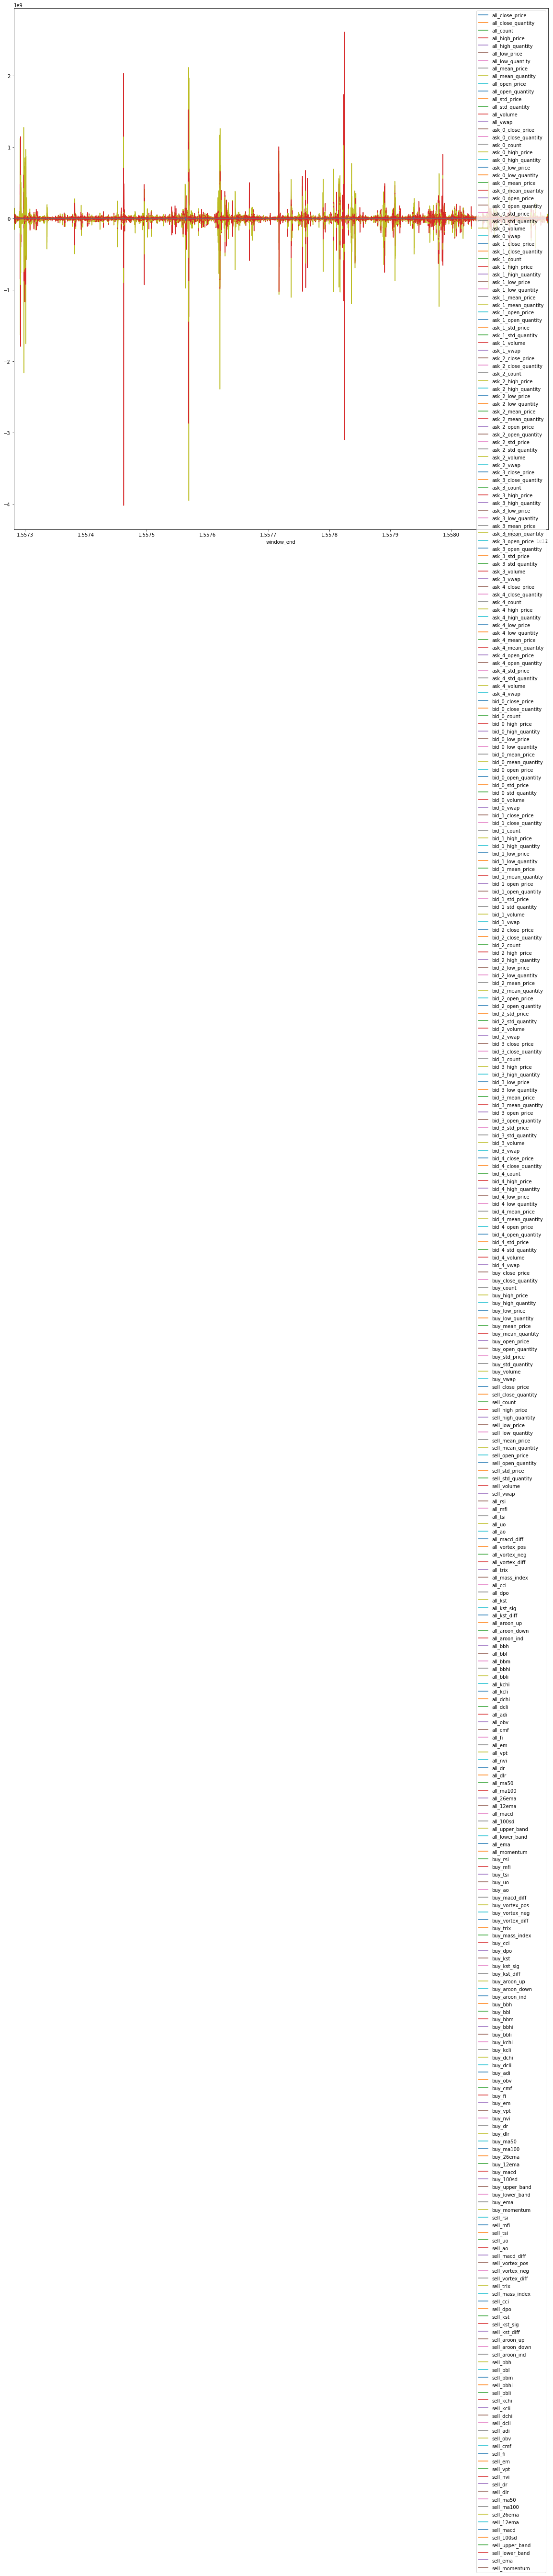

In [211]:
xdf[1500:].plot(figsize=(20,20))

In [199]:
ffd8_close = frac_diff_ffd(dff['all_close_price', 'high_close_price'], 0.4)

KeyError: ('all_close_price', 'high_close_price')

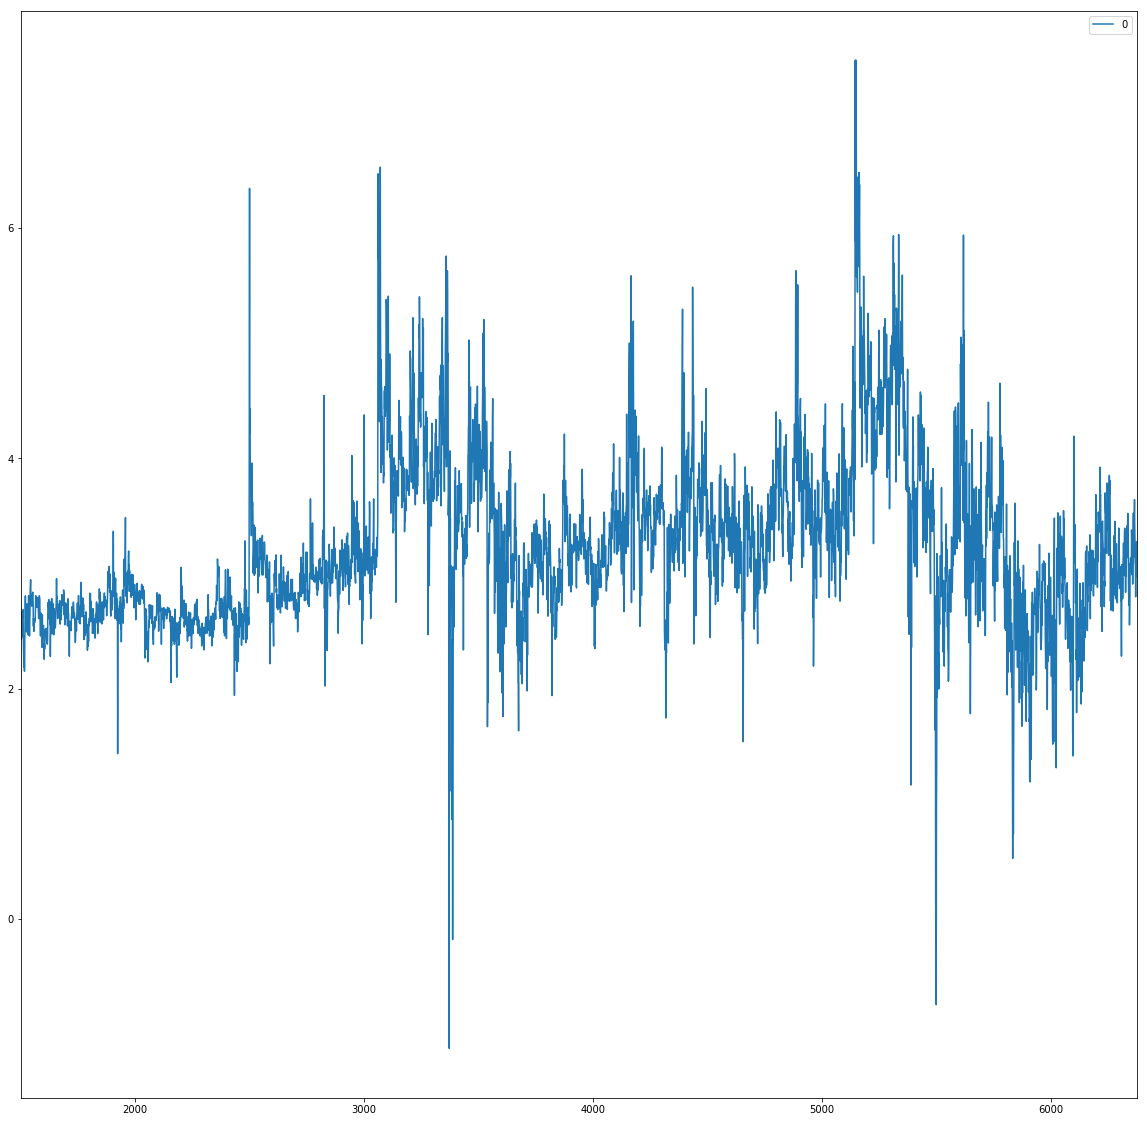

In [187]:
pd.DataFrame(ffd_close)[1500:].plot(figsize=(20,20))

In [56]:
df.head()

,all_close_price,all_close_quantity,all_count,all_high_price,all_high_quantity,all_low_price,all_low_quantity,all_mean_price,all_mean_quantity,all_open_price,...,sell_ma50,sell_ma100,sell_26ema,sell_12ema,sell_macd,sell_100sd,sell_upper_band,sell_lower_band,sell_ema,sell_momentum
window_end,,,,,,,,,,,,,,,,,,,,,
1557011879999,77.65,31.060000,369.0,77.74,5245.393094,77.47,0.129271,77.590813,342.360239,77.53,...,77.6226,77.4287,77.650000,77.650000,0.000000,0.277891,77.984482,76.872918,77.650000,76.65
1557012059999,77.75,0.379187,381.0,77.82,6267.614516,77.60,0.194017,77.710997,264.079526,77.63,...,77.6226,77.4287,77.701923,77.704167,0.002244,0.277891,77.984482,76.872918,77.725000,76.75
1557012239999,77.66,0.517293,336.0,77.81,6675.284814,77.60,0.000078,77.702351,324.307814,77.74,...,77.6226,77.4287,77.686861,77.686928,0.000068,0.277891,77.984482,76.872918,77.680000,76.66
1557012419999,77.81,163.479744,334.0,77.83,5099.647956,77.69,0.033117,77.754820,362.312440,77.70,...,77.6226,77.4287,77.721285,77.725777,0.004492,0.277891,77.984482,76.872918,77.767750,76.81
1557012599999,77.90,0.623200,376.0,78.01,8150.531142,77.76,0.093480,77.902447,282.780370,77.83,...,77.6226,77.4287,77.762730,77.773113,0.010383,0.277891,77.984482,76.872918,77.856281,76.90


In [66]:
dfa = df.copy()

In [67]:
dfa['all_close_price'] = dfa['all_close_price'].shift(-1)
dfa.replace([np.inf, -np.inf], np.nan, inplace=True)
dfa.fillna(method='bfill', inplace=True)
dfa.fillna(method='ffill', inplace=True)

In [ ]:
metcol = [
    'interval',
    'quote_asset', 
    'base_asset',
    'exchange'
]

indcol = metcol + [
    'all_close_price', 
    'all_volume', 
    'all_high_price'
]

indf = dfa[indcol]

indf.rename(
    columns={
        "all_close_price": "close_price", 
        "all_volume":"volume", 
        "all_high_price": "high_price"
    }, 
    inplace=True
)

dfa.drop(
    columns=metcol, 
    inplace=True
)

In [ ]:
# Without any stationarity

In [ ]:
regressora = xgb.XGBRegressor(gamma=0.0,n_estimators=500,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [72]:
X = dfa.loc[:, dfa.columns != 'all_close_price']
y = dfa.loc[:, dfa.columns == 'all_close_price']

In [75]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [84]:
xgbModel = regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

[03:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


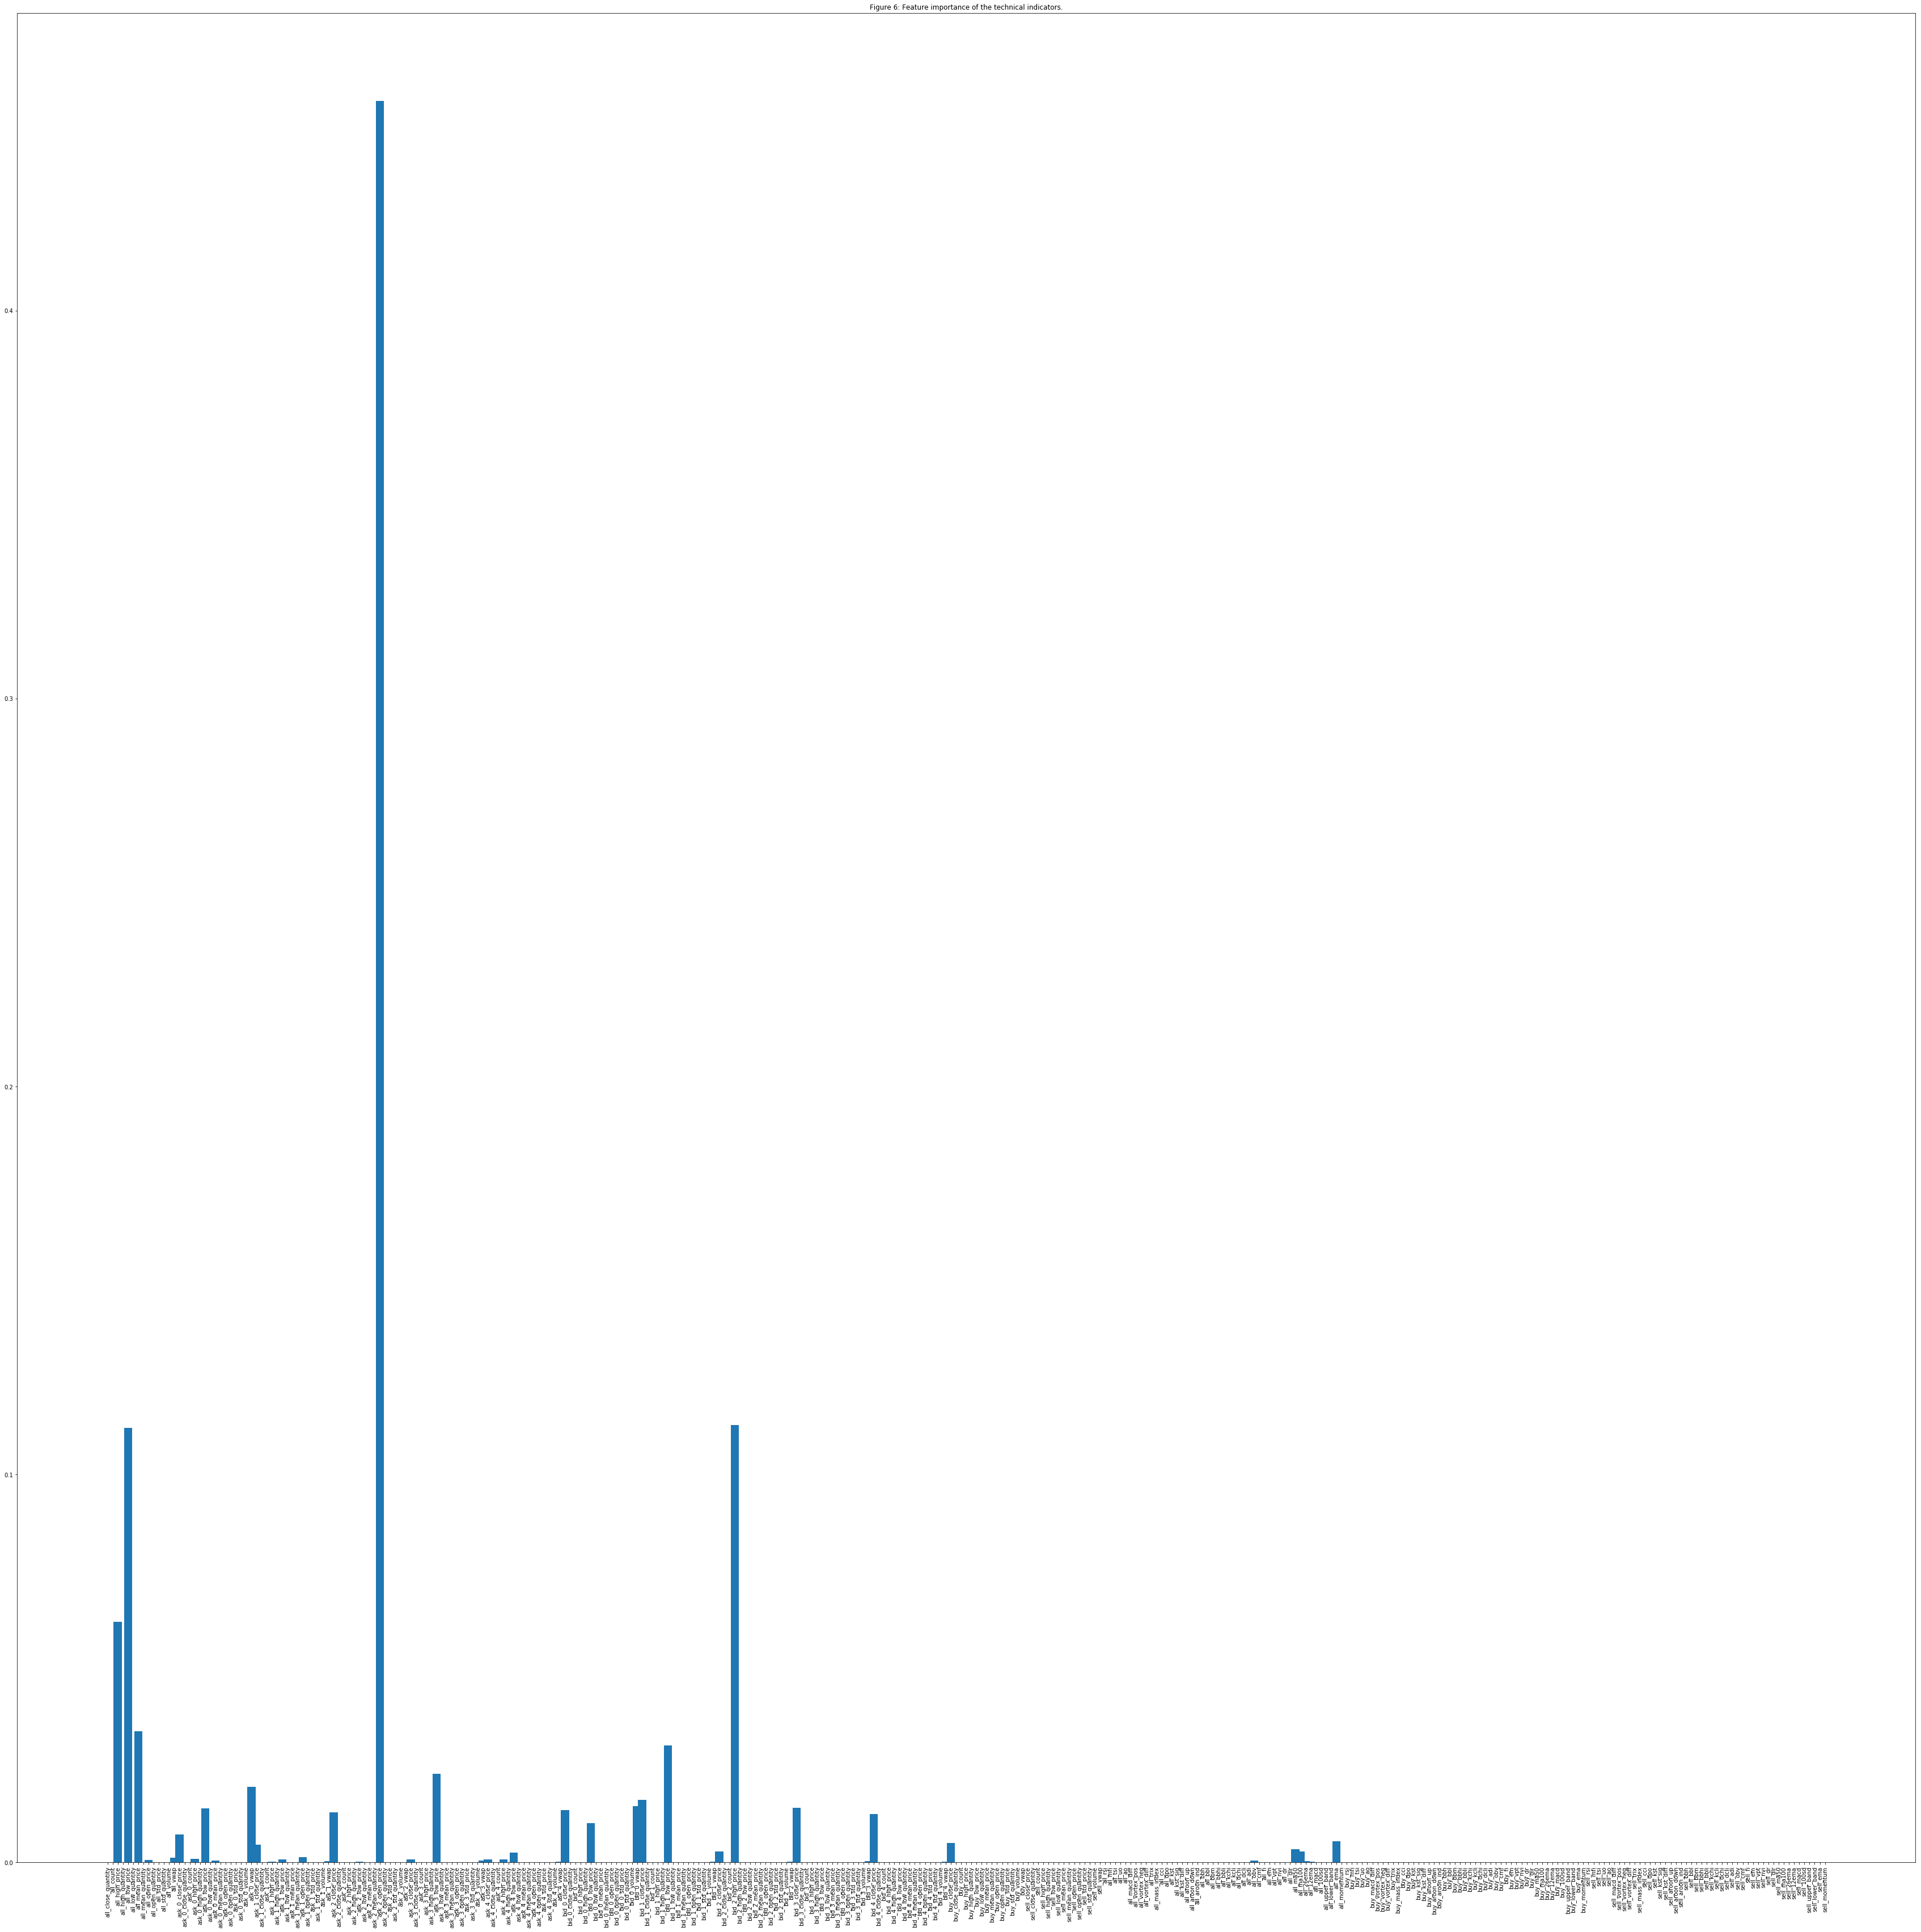

In [85]:
fig = plt.figure(figsize=(60,60))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns, width=1.6)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [87]:
preds =  regressor.predict(X_test)

In [89]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.340713


In [92]:
# Log Diff Stationarity

In [102]:
regressorb = xgb.XGBRegressor(gamma=0.0,n_estimators=500,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [103]:
dfb = dfa.copy()

In [104]:
def log_and_difference(df, columns):
    transformed_df = df.copy()
    transformed_df[df.eq(0)] = 1E-10
    for column in columns:
        x = np.log(transformed_df[column])
        y = np.log(transformed_df[column]).shift(1)
        transformed_df[column] = x - y
    transformed_df = transformed_df.fillna(method='bfill').fillna(method='ffill')
    return transformed_df

sdfb = log_and_difference(dfb, dfb.columns.values)

/home/thorad/.conda/envs/bitcoin/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/thorad/.conda/envs/bitcoin/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [105]:
sdfb.replace([np.inf, -np.inf], np.nan, inplace=True)
sdfb.fillna(method='bfill', inplace=True)
sdfb.fillna(method='ffill', inplace=True)

In [106]:
Xb = sdfb.loc[:, sdfb.columns != 'all_close_price']
yb = sdfb.loc[:, sdfb.columns == 'all_close_price']

In [107]:
data_dmatrix_b = xgb.DMatrix(data=Xb,label=yb)

In [108]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.2, random_state=123)

In [109]:
xgbModelb = regressorb.fit(X_train_b,y_train_b, eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)], verbose=False)

[03:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


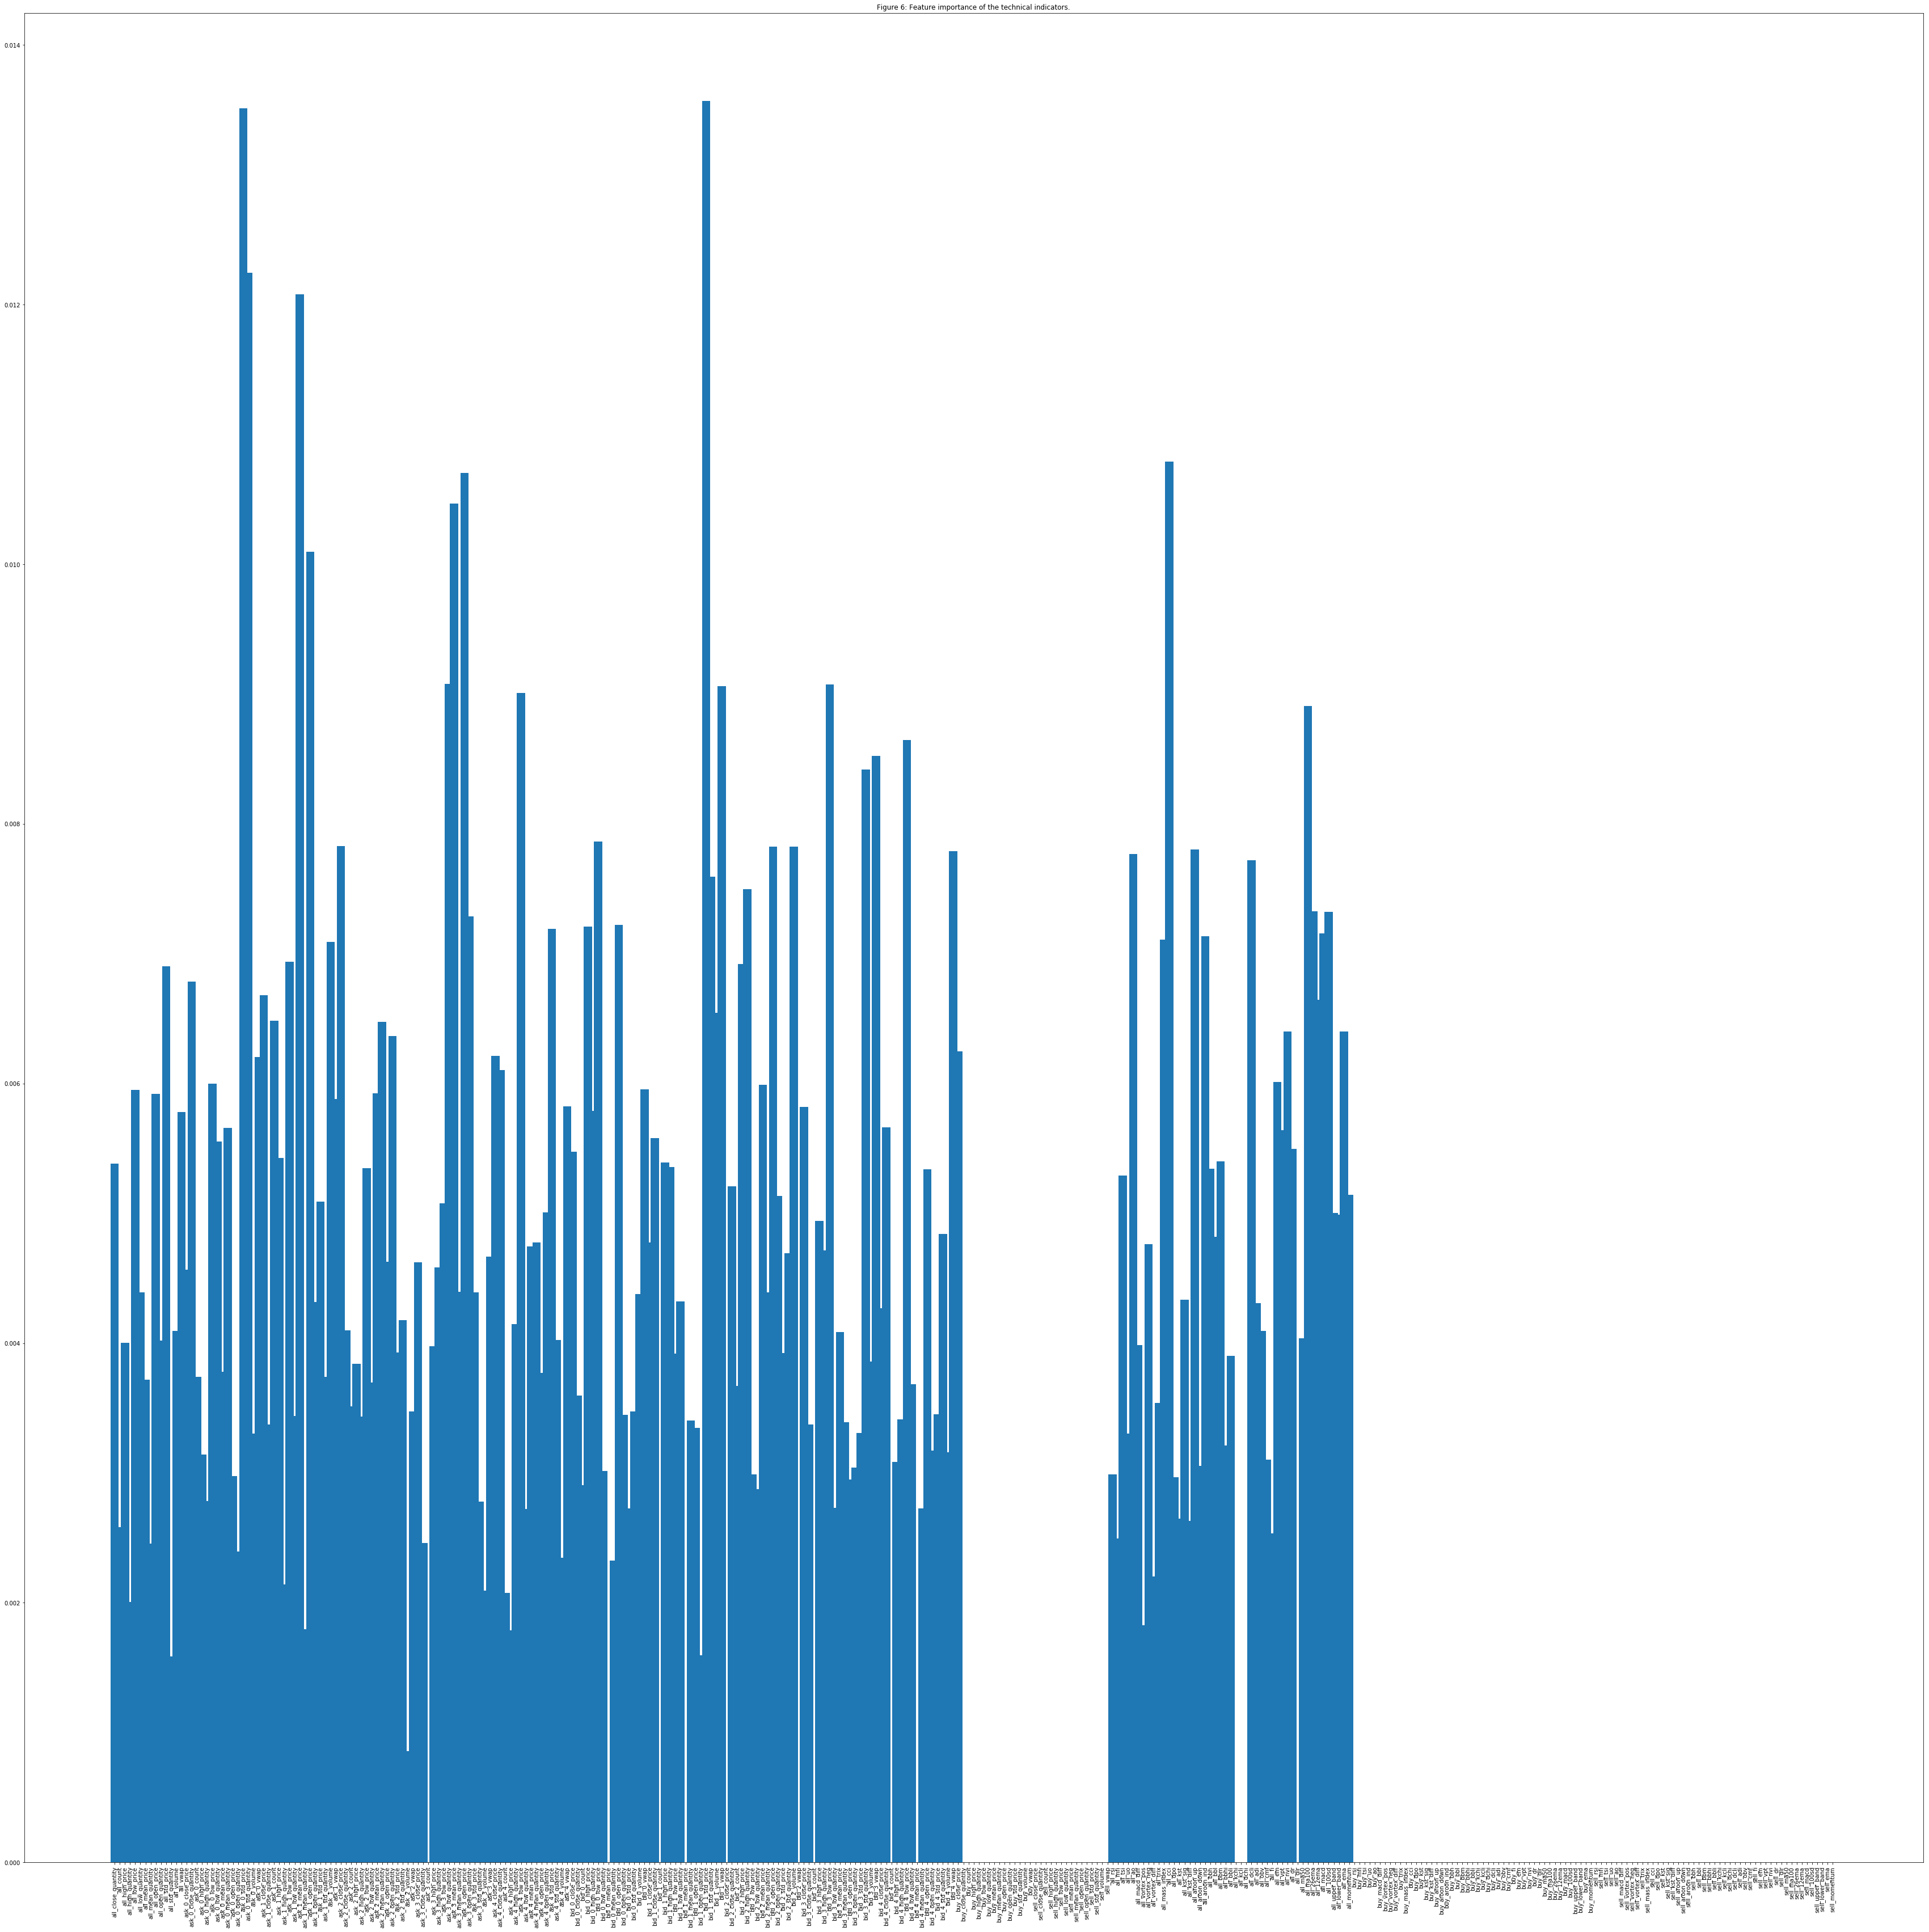

In [110]:
fig = plt.figure(figsize=(60,60))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModelb.feature_importances_))], xgbModelb.feature_importances_.tolist(), tick_label=X_test_b.columns, width=1.6)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [111]:
predsb = regressorb.predict(X_test_b)

In [112]:
rmseb = np.sqrt(mean_squared_error(y_test_b, predsb))
print("RMSE: %f" % (rmseb))

RMSE: 0.003567


In [126]:
# Fractional Differentiation